# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [63]:
%autosave 60

Autosaving every 60 seconds


## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Создадим датафрейм df со столбцами: uid, labname, numTrials, hour, dayofweek

Сначала посмотрим, что в исходном датафрейме

In [3]:
df = pd.read_csv('../data/checker_submits.csv', parse_dates=['timestamp'])
df

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104
...,...,...,...,...
1681,user_19,laba06s,9,2020-05-21 20:01:48.959966
1682,user_1,laba06s,6,2020-05-21 20:18:54.487900
1683,user_1,laba06s,7,2020-05-21 20:19:06.872761
1684,user_1,laba06s,8,2020-05-21 20:22:41.877806


Преределаем столбцы по заданию

In [4]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df = df.drop('timestamp', axis=1)
df

,uid,labname,numTrials,hour,dayofweek
0,user_4,project1,1,5,4
1,user_4,project1,2,5,4
2,user_4,project1,3,5,4
3,user_4,project1,4,5,4
4,user_4,project1,5,5,4
...,...,...,...,...,...
1681,user_19,laba06s,9,20,3
1682,user_1,laba06s,6,20,3
1683,user_1,laba06s,7,20,3
1684,user_1,laba06s,8,20,3


Мы попытаемся предсказать день недели, имея данные о том, какой пользователь сделал коммит, для какой лаборатории, в какое время и какая это была попытка.

Используя OneHotEncoder(), преобразуем свои категориальные функции, удалим из датафрейма исходные столбцы.

In [5]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])
df

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,1,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,9,20,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,6,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,7,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,8,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Используя StandardScaler(), масштабируем непрерывные функции.

In [6]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])
df

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,-0.629151,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,-0.597248,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,-0.565345,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Сохраним датафрейм

In [8]:
df.to_csv('../data/dayofweek.csv', index=False)

Прежде чем пробовать разные алгоритмы, узнаем точность наивного алгоритма — того, который все предсказывает как самый популярный класс.

In [9]:
X = df.drop('dayofweek', axis=1)
y = df['dayofweek']
y_pred_naive = np.array([np.argmax(np.bincount(y))] * len(y))

In [10]:
accuracy_score(y, y_pred_naive)

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

Обучим логистическую регрессию для базовой модели, используя random_state=21, fit_intercept=False. Рассчитаем точность.

In [11]:
lr = LogisticRegression(random_state=21, fit_intercept=False)
lr.fit(X, y)
y_pred = lr.predict(X)
accuracy_score(y, y_pred)

0.6405693950177936

Построим график (barh) на основании рассчитанных коэффициентов регрессии для n наиболее значимых фичей

In [12]:
def plot_features(coefs, features, n=10):
    fig, ax = plt.subplots(figsize=(15, 8)) # определяем параметры графика
    coefs /= coefs.sum() # коэффициенты берем с удельным весом
    indices = coefs.argsort()[::-1][:n] # индексами берем фичи (аргументы коэффициентов регрессии), отсортированные по возрастанию, поэтому срез с конца, последние n
    ax.barh(np.arange(n), coefs[indices], color='green')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(features[indices])
    ax.invert_yaxis() # сделаем, чтобы более значимые фичи были сверху
    plt.show()

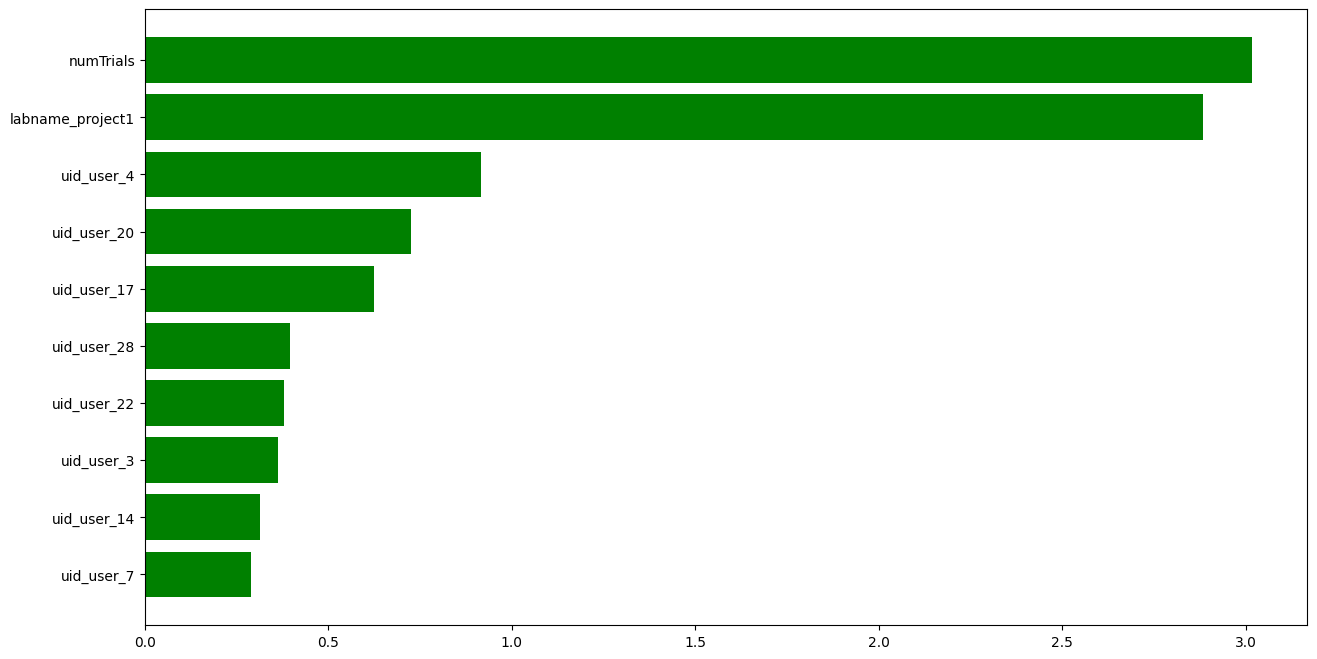

In [13]:
plot_features(lr.coef_.mean(axis=0), X.columns)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

SVS - метод опорных векторов.

http://datascientist.one/support-vector-machines/

Обучим модель SVC, используйя параметры ядра = 'линейный', вероятность = истина, random_state = 21

In [14]:
svc = SVC(kernel='linear', probability=True, random_state=21)
svc.fit(X, y)
y_svc = svc.predict(X)

In [15]:
accuracy_score(y, y_svc)

0.702846975088968

Нарисуйем график для базовой модели с 10 наиболее важными функциями (абсолютное значение веса) для обученной модели для линейного ядра

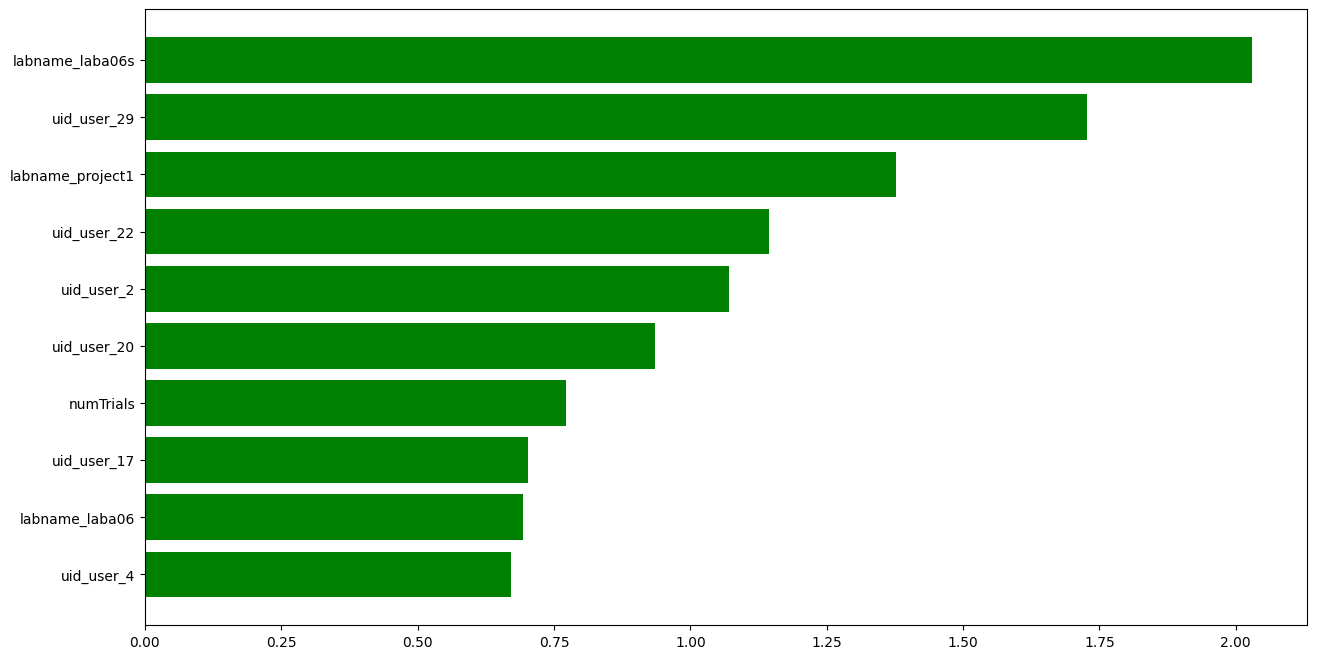

In [16]:
plot_features(svc.coef_.mean(axis=0), X.columns)

Пробуем разные ядра, посчитаем точность.

In [17]:
svc = SVC(probability=True, random_state=21)
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
gs = GridSearchCV(svc, param_grid, scoring='accuracy')
gs.fit(X, y)
gs.best_params_

{'kernel': 'poly'}

Лучшим ядром оказалось poly

In [18]:
y_pred = gs.predict(X)
accuracy_score(y, y_pred)

0.8594306049822064

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

Обучим DecisionTreeClassifier, используя для базовой модели max_depth=4, random_state=21.

In [19]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

0.5516014234875445

Попробуем разные значения max_depth, рассчитаем точность.

In [20]:
dtc = DecisionTreeClassifier(max_depth=6, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

0.6637010676156584

In [21]:
dtc = DecisionTreeClassifier(max_depth=8, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

0.7502965599051008

In [22]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

0.8196915776986952

In [23]:
dtc = DecisionTreeClassifier(max_depth=12, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

0.8831553973902728

In [24]:
dtc = DecisionTreeClassifier(max_depth=28, random_state=21)
dtc.fit(X, y)
y_dts = dtc.predict(X)
accuracy_score(y, y_dts)

1.0

При увеличении глубины точность увеличивается. При глубине 28 достигается 1. Система становится переобученной.

Нарисуем график для базовой модели с 10 наиболее важными фичами (по абсолютному значению) для обученной модели, используя написанную функцию.

In [25]:
dtc = DecisionTreeClassifier(random_state=21)
param_grid = {'max_depth': [3, 5, 7, 10, 20, 28]}
gs = GridSearchCV(dtc, param_grid, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 20, 28]},
             scoring='accuracy')

In [26]:
gs.best_params_

{'max_depth': 20}

In [27]:
y_pred = gs.predict(X)
accuracy_score(y, y_pred)

0.9869513641755635

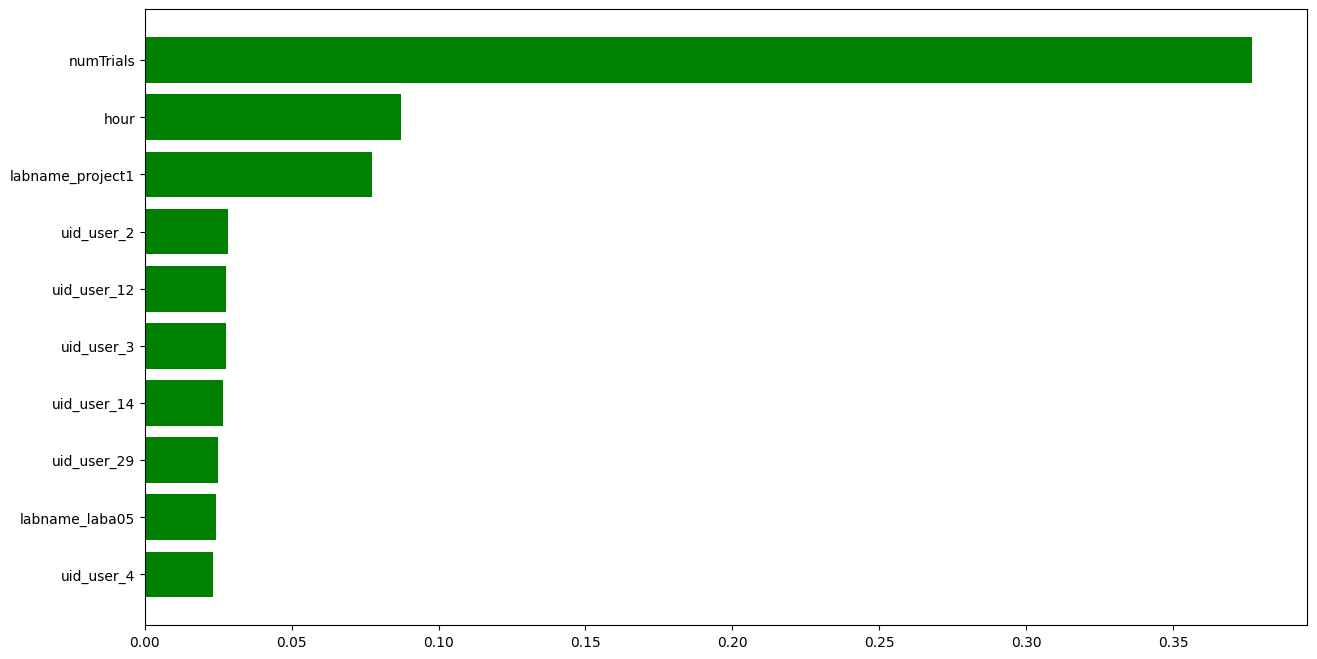

In [28]:
plot_features(gs.best_estimator_.feature_importances_, X.columns)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

Обучим RandomForestClassifier, используя параметры базовой модели n_estimators=100, max_depth = 25, random_state=21.

In [29]:
rfm = RandomForestClassifier(n_estimators=100,
                             max_depth=25,
                             random_state=21)
rfm.fit(X, y) # обучение
y_rfm = rfm.predict(X) # предсказание

accuracy_score(y, y_rfm)

1.0

Попробуем разные значения max_depth и n_estimators, рассчитаем точность.

In [30]:
rfm = RandomForestClassifier(n_estimators=10,
                             max_depth=25,
                             random_state=21)
rfm.fit(X, y) # обучение
y_rfm = rfm.predict(X) # предсказание

accuracy_score(y, y_rfm)

0.9958481613285883

In [31]:
rfm = RandomForestClassifier(n_estimators=100,
                             max_depth=20,
                             random_state=21)
rfm.fit(X, y) # обучение
y_rfm = rfm.predict(X) # предсказание

accuracy_score(y, y_rfm)

0.99644128113879

Нарисуем график для базовой модели с 10 наиболее важными функциями (по абсолютному значению) для обученной модели, используя написанную функцию.

In [32]:
rfm = RandomForestClassifier(random_state=21)
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 5, 7, 10, 20, 25, 30]}
gs = GridSearchCV(rfm, param_grid, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 20, 25, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [33]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 200}

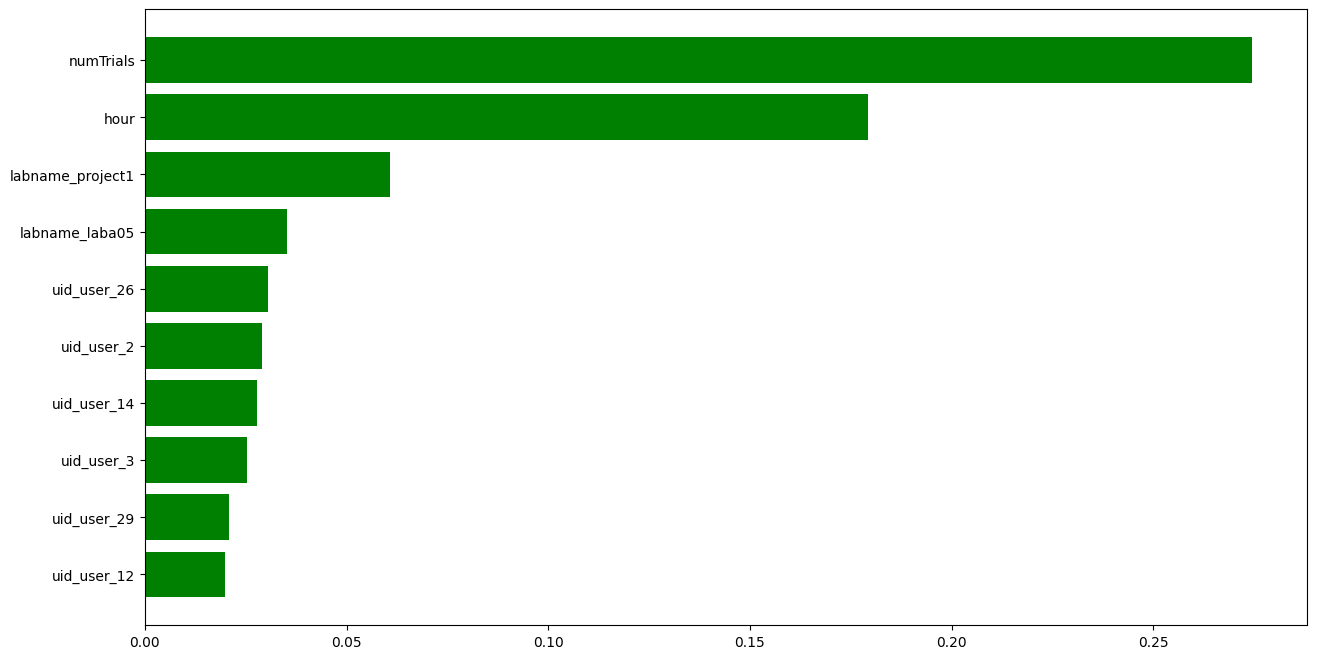

In [34]:
plot_features(gs.best_estimator_.feature_importances_, X.columns)